<a href="https://colab.research.google.com/github/kalebsampaco/Ejercicios-en-google-colab/blob/master/redes_convolucionales_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


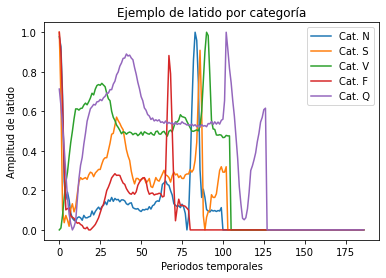

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

KeyError: ignored

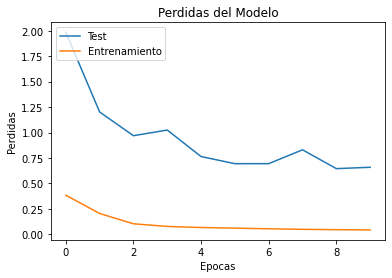

<Figure size 432x288 with 0 Axes>

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.signal import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Add, Flatten, Activation,Dropout
from keras.optimizers import Adam
import keras

#DEFINICIONES
batch_size = 500
lr=0.001

#APERTURA DE FICHEROS CSV CON LA BASE DE DATOS
f = pd.read_csv("/mitbih_train.csv", header=None)
f2 = pd.read_csv("/mitbih_test.csv", header=None)
f = pd.concat([f, f2], axis=0)

#CONVERSION DE DATOS Y OBTENCIÓN DE LAS DIFERENTES CLASES EN C0-C4
Valores = f.values
entradas = Valores[:, :-1]
salidas = Valores[:, -1].astype(int)
Clase_0 = np.argwhere(salidas== 0).flatten()
Clase_1 = np.argwhere(salidas == 1).flatten()
Clase_2 = np.argwhere(salidas == 2).flatten()
Clase_3 = np.argwhere(salidas == 3).flatten()
Clase_4 = np.argwhere(salidas == 4).flatten()

#VISUALIZACIÓN DE EJEMPLOS DE LAS DIFERENTES CLASES QUE BUSCAMOS SEPARAR
plt.figure(1)
plt.plot(entradas[Clase_0, :][0], label="Cat. N")
plt.plot(entradas[Clase_1, :][0], label="Cat. S")
plt.plot(entradas[Clase_2, :][0], label="Cat. V")
plt.plot(entradas[Clase_3, :][0], label="Cat. F")
plt.plot(entradas[Clase_4, :][0], label="Cat. Q")
plt.legend()
plt.title("Ejemplo de latido por categoría")
plt.ylabel("Amplitud de latido")
plt.xlabel("Periodos temporales")
plt.show()




#Selección de x muestras aleatoriamente

setClase_0 = np.random.choice(Clase_0, 1000)
setClase_1 = np.random.choice(Clase_1, 1000)
setClase_2 = np.random.choice(Clase_2, 1000)
setClase_3 = np.random.choice(Clase_3, 1000)
setClase_4 = np.random.choice(Clase_4, 1000)

entradas_test = np.vstack([entradas[setClase_0], entradas[setClase_1], entradas[setClase_2], entradas[setClase_3], entradas[setClase_4]])
salidas_test = np.hstack([salidas[setClase_0], salidas[setClase_1], salidas[setClase_2], salidas[setClase_3], salidas[setClase_4]])
entradas_train = np.delete(entradas, [setClase_0, setClase_1, setClase_2, setClase_3, setClase_4], axis=0)
salidas_train = np.delete(salidas, [setClase_0, setClase_1, setClase_2, setClase_3, setClase_4], axis=0)
entradas_train = np.expand_dims(entradas_train, 2)
entradas_test = np.expand_dims(entradas_test, 2)

#Codificación de etiquetas
nclases=5
salidas_train=keras.utils.to_categorical(salidas_train,nclases)
salidas_test=keras.utils.to_categorical(salidas_test,nclases)

#Creacion de Modelo
muestras, caracteristicas, profundidad = entradas_train.shape


def residualblock(entrada,filtros,kernel):
    x = Conv1D(filters=filtros, kernel_size=kernel, strides=1)(entrada)
    x = Conv1D(filters=filtros, kernel_size=kernel, strides=1, padding='same')(x)
    x = Activation("relu")(x)
    x = Conv1D(filters=filtros, kernel_size=kernel, strides=1, padding='same')(x)
    x2 = Conv1D(filters=filtros, kernel_size=kernel, strides=1)(entrada)
    fusion = Add()([x, x2])
    fusion = Activation("relu")(fusion)
    return fusion

entrada = Input(shape=(caracteristicas, profundidad))
x=residualblock(entrada=entrada,filtros=32,kernel=5)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x=residualblock(entrada=x,filtros=64,kernel=5)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Flatten()(x)
x = Dense(12,activation='relu')(x)
x = Dense(5,activation='softmax')(x)

model = Model(inputs=entrada, outputs=x)
model.summary()
adam = Adam(lr = lr, beta_1 = 0.9, beta_2 = 0.999)


model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])

history = model.fit(entradas_train, salidas_train, epochs=10, batch_size=batch_size, verbose=2, validation_data=(entradas_test, salidas_test),shuffle=True)

#visualizacion de resultaoos
plt.figure(1)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Perdidas del Modelo')
plt.ylabel('Perdidas')
plt.xlabel('Epocas')
plt.legend(['Test','Entrenamiento'], loc='upper left')

plt.figure(2)
plt.plot(history.history['val_binary_accuracy'])
plt.plot(history.history['binary_accuracy'])
plt.title('Precision del Modelo')
plt.ylabel('Precision')
plt.xlabel('Epocas')
plt.legend(['Test','Entrenamiento'], loc='upper left')